### 导入实验环境

#### 导入库

In [43]:
import os
import struct
import sys
from easydict import EasyDict as edict

import matplotlib.pyplot as plt
import numpy as np

import mindspore
import mindspore.dataset as ds
import mindspore.nn as nn
from mindspore import context
from mindspore.nn.metrics import Accuracy
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore import Tensor

context.set_context(mode=context.GRAPH_MODE, device_target='CPU') 


#### 定义常量

In [44]:
cfg = edict({
    # 'train_size': 60000,  # 训练集大小
    # 'test_size': 10000,  # 测试集大小
    'train_size': 600,  # 训练集大小
    'test_size': 100,  # 测试集大小
    'channel': 1,  # 图片通道数
    'image_height': 28,  # 图片高度
    'image_width': 28,  # 图片宽度
    'batch_size': 64,
    'num_classes': 10,  # 分类类别
    'lr': 0.001,  # 学习率
    'epoch_size': 1,  # 训练次数
    'data_dir_train': os.path.join('fashion-mnist', 'train'),
    'data_dir_test': os.path.join('fashion-mnist', 'test'),
}) 


### 数据读取和预处理

#### 步骤 1	定义函数用于读取数据

In [45]:
def read_image(file_name):
    '''
    :param file_name: 文件路径
    :return:  训练或者测试数据
    如下是训练的图片的二进制格式
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>IIII', file_content, 0)  # 取前4个整数，返回一个元组
    offset = struct.calcsize('>IIII')
    imgNum = head[1]  # 图片数
    width = head[2]  # 宽度
    height = head[3]  # 高度
    bits = imgNum * width * height  # data一共有60000*28*28个像素值
    bitsString = '>' + str(bits) + 'B'  # fmt格式：'>47040000B'
    imgs = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    imgs_array = np.array(imgs, np.float32).reshape((imgNum, width * height))  # 最后将读取的数据reshape成 【图片数，图片像素】二维数组
    return imgs_array


def read_label(file_name):
    '''
    :param file_name:
    :return:
    标签的格式如下：
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>II', file_content, 0)  # 取前2个整数，返回一个元组
    offset = struct.calcsize('>II')
    labelNum = head[1]  # label数
    bitsString = '>' + str(labelNum) + 'B'  # fmt格式：'>47040000B'
    label = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    return np.array(label, np.int32)


def get_data():
    # 文件获取
    train_image = os.path.join(cfg.data_dir_train, 'train-images-idx3-ubyte')
    test_image = os.path.join(cfg.data_dir_test, "t10k-images-idx3-ubyte")
    train_label = os.path.join(cfg.data_dir_train, "train-labels-idx1-ubyte")
    test_label = os.path.join(cfg.data_dir_test, "t10k-labels-idx1-ubyte")
    # 读取数据
    train_x = read_image(train_image)
    test_x = read_image(test_image)
    train_y = read_label(train_label)
    test_y = read_label(test_label)
    return train_x, train_y, test_x, test_y


#### 数据预处理

训练数据集样本数： 60000
测试数据集样本数： 10000
通道数/图像长/宽： (1, 28, 28)
一张图像的标签样式： 9


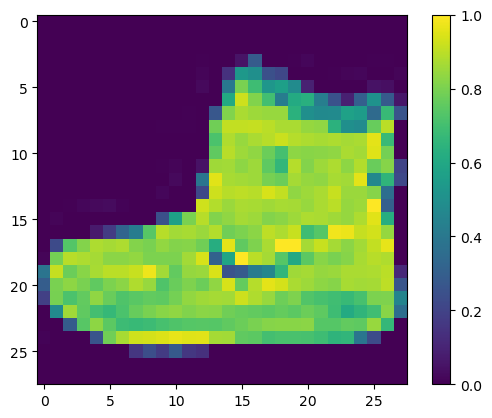

In [46]:
train_x, train_y, test_x, test_y = get_data()
train_x = train_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
test_x = test_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
train_x = train_x / 255.0
test_x = test_x / 255.0

print('训练数据集样本数：', train_x.shape[0])
print('测试数据集样本数：', test_y.shape[0])
print('通道数/图像长/宽：', train_x.shape[1:])
print('一张图像的标签样式：', train_y[0])  # 一共10类，用0-9的数字表达类别。

plt.figure()
plt.imshow(train_x[0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()


#### 数据集预处理

In [47]:
# 转换数据类型为Dataset
def create_dataset():
    XY_train = list(zip(train_x, train_y))
    ds_train = ds.GeneratorDataset(XY_train, ['x', 'y'])
    ds_train = ds_train.shuffle(buffer_size=1000).batch(cfg.batch_size, drop_remainder=True)
    XY_test = list(zip(test_x, test_y))
    ds_test = ds.GeneratorDataset(XY_test, ['x', 'y'])
    ds_test = ds_test.shuffle(buffer_size=1000).batch(cfg.batch_size, drop_remainder=True)
    return ds_train, ds_test 


### 训练模型

In [48]:
# 定义卷积神经网络，BaseLine
class ForwardFashion(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashion, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(128 * 11 * 11, 128)
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [49]:
# 定义卷积神经网络，有正则化
class ForwardFashionRegularization(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashionRegularization, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(3200, 128)
        self.bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [50]:
# 定义卷积神经网络，有Dropout正则化
class ForwardFashionWithDropout(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashionWithDropout, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(3200, 128)
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


#### 启动训练

In [51]:
def train(Net):
    ds_train, ds_test = create_dataset()
    # 构建网络
    network = Net(cfg.num_classes)
    # 定义模型的损失函数，优化器
    net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
    net_opt = nn.Adam(network.trainable_params(), cfg.lr)
    # 训练模型
    model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'acc': Accuracy()})
    loss_cb = LossMonitor()
    print("============== Starting Training ==============")
    model.train(cfg.epoch_size, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
    # 验证
    metric = model.eval(ds_test)
    print(metric)
    
    return model


In [52]:
# 训练无正则化的网络
model = train(ForwardFashion)


============== Starting Training ==============
epoch: 1 step: 1, loss is 2.3025851249694824
epoch: 1 step: 2, loss is 2.3024115562438965
epoch: 1 step: 3, loss is 2.3024981021881104
epoch: 1 step: 4, loss is 2.3017826080322266
epoch: 1 step: 5, loss is 2.300419569015503
epoch: 1 step: 6, loss is 2.2962634563446045
epoch: 1 step: 7, loss is 2.279592752456665
epoch: 1 step: 8, loss is 2.263939142227173
epoch: 1 step: 9, loss is 2.2377941608428955
epoch: 1 step: 10, loss is 2.165936231613159
epoch: 1 step: 11, loss is 2.0613808631896973
epoch: 1 step: 12, loss is 1.9758968353271484
epoch: 1 step: 13, loss is 1.841408610343933
epoch: 1 step: 14, loss is 1.7683721780776978
epoch: 1 step: 15, loss is 1.435143232345581
epoch: 1 step: 16, loss is 1.137600064277649
epoch: 1 step: 17, loss is 1.6107063293457031
epoch: 1 step: 18, loss is 1.3166133165359497
epoch: 1 step: 19, loss is 1.108257532119751
epoch: 1 step: 20, loss is 1.2429336309432983
epoch: 1 step: 21, loss is 1.4975557327270508
epo

In [55]:
# 训练有正则化的网络
model = train(ForwardFashionRegularization)


[WARNING] ME(16032:21436,MainProcess):2023-05-14-19:22:32.891.227 [mindspore\nn\layer\basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(16032:21436,MainProcess):2023-05-14-19:22:32.926.230 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(16032:21436,MainProcess):2023-05-14-19:22:32.930.228 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(16032:21436,MainProcess):2023-05-14-19:22:32.940.229 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(16032:21436,MainProcess):2023-05-14-19:22:32.941.231 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(16032:21436,MainProcess):2023-05-14-19:22:32.967.239 [mindspore\nn\

============== Starting Training ==============
epoch: 1 step: 1, loss is 2.2993295192718506
epoch: 1 step: 2, loss is 2.287247657775879
epoch: 1 step: 3, loss is 2.253066062927246
epoch: 1 step: 4, loss is 2.159172296524048
epoch: 1 step: 5, loss is 2.1047818660736084
epoch: 1 step: 6, loss is 2.0446059703826904
epoch: 1 step: 7, loss is 1.9721177816390991
epoch: 1 step: 8, loss is 1.944969654083252
epoch: 1 step: 9, loss is 1.904735803604126
epoch: 1 step: 10, loss is 1.8913612365722656
epoch: 1 step: 11, loss is 1.7719639539718628
epoch: 1 step: 12, loss is 1.8083610534667969
epoch: 1 step: 13, loss is 1.7371975183486938
epoch: 1 step: 14, loss is 1.7522292137145996
epoch: 1 step: 15, loss is 1.6234487295150757
epoch: 1 step: 16, loss is 1.7264823913574219
epoch: 1 step: 17, loss is 1.6801667213439941
epoch: 1 step: 18, loss is 1.7266433238983154
epoch: 1 step: 19, loss is 1.6262800693511963
epoch: 1 step: 20, loss is 1.6261721849441528
epoch: 1 step: 21, loss is 1.5996160507202148


[WARNING] ME(16032:21436,MainProcess):2023-05-14-19:23:45.598.502 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(16032:21436,MainProcess):2023-05-14-19:23:45.606.503 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(16032:21436,MainProcess):2023-05-14-19:23:45.617.501 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(16032:21436,MainProcess):2023-05-14-19:23:45.639.501 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(16032:21436,MainProcess):2023-05-14-19:23:45.651.502 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


{'acc': 0.858573717948718}


#### 预测模型

In [ ]:
# 预测
ds_test, _ = create_dataset()
test_ = ds_test.create_dict_iterator(output_numpy=True).__next__()
predictions = model.predict(Tensor(test_['x']))
predictions = predictions.asnumpy()
for i in range(15):
    p_np = predictions[i, :]
    p_list = p_np.tolist()
    print('第' + str(i) + '个sample预测结果：', p_list.index(max(p_list)), '   真实结果：', test_['y'][i])


[WARNING] ME(16032:21436,MainProcess):2023-05-14-16:58:22.669.214 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(16032:21436,MainProcess):2023-05-14-16:58:22.674.230 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(16032:21436,MainProcess):2023-05-14-16:58:22.684.216 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(16032:21436,MainProcess):2023-05-14-16:58:22.690.230 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


第0个sample预测结果： 7    真实结果： 7
第1个sample预测结果： 9    真实结果： 9
第2个sample预测结果： 8    真实结果： 8
第3个sample预测结果： 0    真实结果： 6
第4个sample预测结果： 1    真实结果： 1
第5个sample预测结果： 1    真实结果： 1
第6个sample预测结果： 1    真实结果： 1
第7个sample预测结果： 3    真实结果： 3
第8个sample预测结果： 5    真实结果： 5
第9个sample预测结果： 3    真实结果： 1
第10个sample预测结果： 3    真实结果： 1
第11个sample预测结果： 6    真实结果： 6
第12个sample预测结果： 3    真实结果： 3
第13个sample预测结果： 7    真实结果： 7
第14个sample预测结果： 9    真实结果： 9


#### 可视化结果

In [ ]:
# -------------------定义可视化函数--------------------------------
# 输入预测结果序列，真实标签序列，以及图片序列
# 目标是根据预测值对错，让其标签显示为红色或者蓝色。对：标签为红色；错：标签为蓝色
def plot_image(predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    # 显示对应图片
    plt.imshow(img, cmap=plt.cm.binary)
    # 显示预测结果的颜色，如果对上了是蓝色，否则为红色
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    # 显示对应标签的格式，样式
    plt.xlabel('{},{:2.0f}% ({})'.format(class_names[predicted_label],
                                         100 * np.max(predictions_array),
                                         class_names[true_label]), color=color)
# 将预测的结果以柱状图形状显示蓝对红错
def plot_value_array(predictions_array, true_label):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    this_plot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    this_plot[predicted_label].set_color('red')
    this_plot[true_label].set_color('blue')

import numpy as np
def softmax_np(x):
    x = x - np.max(x)
    exp_x = np.exp(x)
    softmax_x = exp_x/np.sum(exp_x)
    return softmax_x


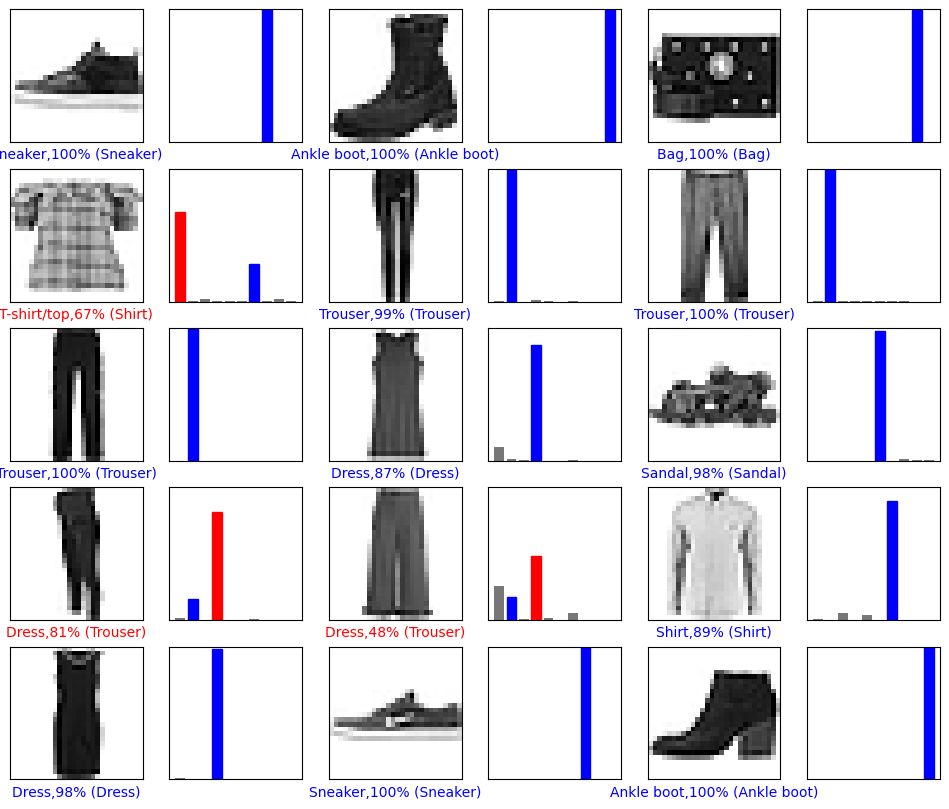

In [ ]:
# 预测15个图像与标签，并展现出来
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    pred_np_ = predictions[i, :]
    pred_np_ = softmax_np(pred_np_)
    plot_image(pred_np_, test_['y'][i], test_['x'][i, 0, ...])
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(pred_np_, test_['y'][i])
plt.show() 
